# Cats v/s Dogs Classification using a RestNet12 Convolutional Neural Network from scratch.

In [1]:
!pip install opendatasets --quiet

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [13]:
from torchvision.datasets import ImageFolder

In [3]:
import zipfile
import opendatasets as od
import os

In [4]:
from numpy import asarray
from PIL import Image

In [5]:
url = 'https://www.kaggle.com/cashutosh/gender-classification-dataset'
od.download(url)
# #download_url(url,'.')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: royalalbert
Your Kaggle Key: ··········


100%|██████████| 269M/269M [00:09<00:00, 30.4MB/s]


In [105]:
classes = ['Female','Male']
classes

['Female', 'Male']

In [64]:
image_size = 84
batch_size = 256
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [65]:
train_path = 'gender-classification-dataset/Training'

train_ds = ImageFolder(train_path, transform=T.Compose([
    T.Resize((image_size,image_size)),
    T.RandomCrop(image_size),
    T.Pad(10, padding_mode = 'reflect'),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)]))

In [66]:
val_pct = 0.1
val_size = int(val_pct * len(train_ds))

train_ds, valid_ds = random_split(train_ds, [len(train_ds) - val_size, val_size])

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [180]:
test_path = 'gender-classification-dataset/Validation'

transformer = T.Compose([T.Resize((104,104)),  # resizing all images into 250*250 pixels 
                        T.ToTensor(),
                         T.Normalize(*imagenet_stats)])

test_ds = ImageFolder(test_path, transform = transformer)
test_dl = DataLoader(test_ds, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [106]:
img,tar = train_ds[4005]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(54,36;334.8x217.44)
Male


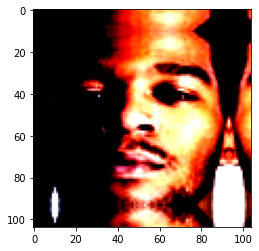

In [107]:
# this is our normalized image
print(plt.imshow(img.permute(1,2,0)))
print(classes[tar])

In [80]:
img.shape

torch.Size([3, 104, 104])

In [81]:
import numpy as np

In [108]:
def denormalize_the_images(image, mean, std):
  if (len(image.shape) == 3):
    image = image.unsqueeze(0)
  mean = torch.tensor(mean).reshape(1,3,1,1) # image ta matrix tensor ma xa. so matrix multiply ra add garda shape eutai huna paryo nita
  std = torch.tensor(std).reshape(1,3,1,1)
  return image * std + mean

In [109]:
def displaying_image(img, label):
  print("Label is: ", label," or ",classes[label])
  denormalized_image_tensor = denormalize_the_images(img, *imagenet_stats)[0]
  plt.imshow(denormalized_image_tensor.permute(1,2,0))

In [110]:
for img,label in train_ds:
  break

In [111]:
label

0

Label is:  0  or  Female


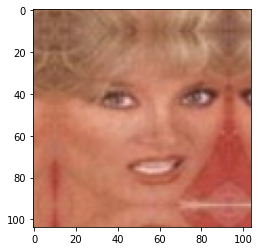

In [112]:
displaying_image(*train_ds[2])

Label is:  0  or  Female


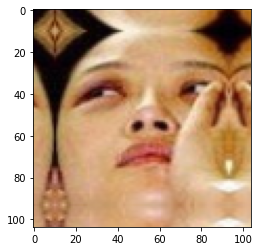

In [114]:
displaying_image(*train_ds[20])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([256, 3, 104, 104])


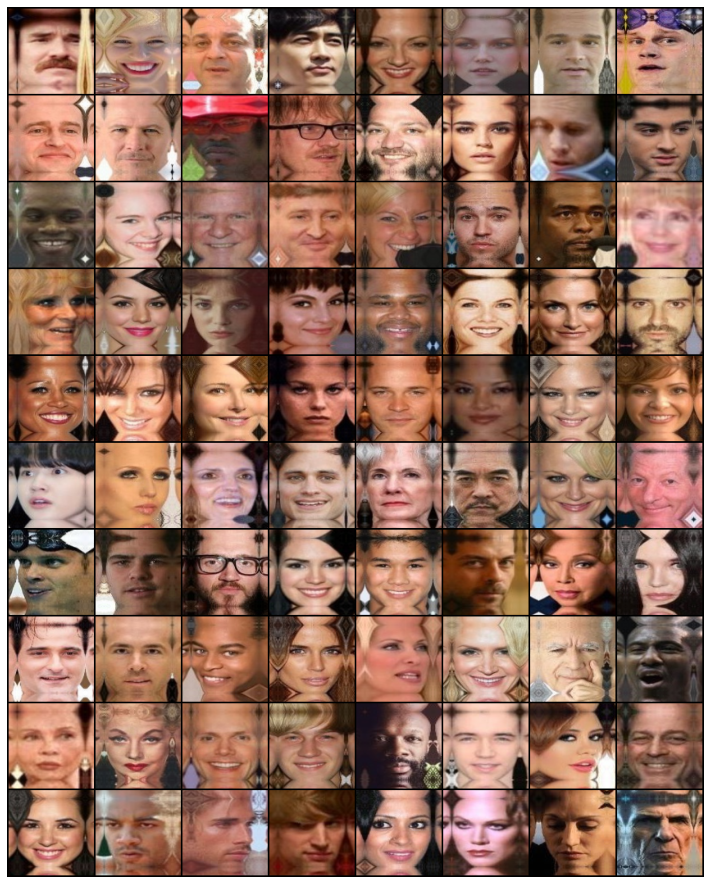

In [117]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    images = denormalize_the_images(images[:80],*imagenet_stats)
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## Creating a RestNet12 CNN Architecture From Scratch

In [118]:
# lets create our logistic regression model
input_size = 3 * 104 * 104
num_classes = 2

In [119]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct_outcomes = torch.sum(preds == labels).item()
    total_outcomes = len(labels)

    accuracy = torch.tensor(correct_outcomes / total_outcomes)
    return round((accuracy.item() * 100),3)

In [120]:
class GenderClassifier(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.tensor(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.tensor(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))     
    

In [121]:
def conv_block(in_channels, out_channels, pool=False, dropout = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    if dropout: layers.append(nn.Dropout2d(0.25))

    return nn.Sequential(*layers)

In [132]:
"""
This is a ResNet17 Convolutional Neural Network that I created from scratch
"""

class ResNet17(GenderClassifier):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # 1st convolutional layer that takes in image with size 224 * 224
        # 3 * 104 * 104
        self.conv1 = conv_block(in_channels, 6)
        # 6 * 104 * 104
        self.conv2 = conv_block(6,12)
        # 12 * 104 * 104
        self.conv3 = conv_block(12,24,pool = True)
        # 24 * 52 * 52
        self.residual_block1 = nn.Sequential(conv_block(24, 48, dropout = True),conv_block(48,24)) # conv layer 4
        # 24 * 52 * 52
        self.conv6 = conv_block(24,48, pool = True)
        # 48 * 26 * 26 
        self.residual_block2 = nn.Sequential(conv_block(48, 96, pool = False, dropout = False), conv_block(96,48))
        # 48 * 26 * 26
        self.conv9 = conv_block(48,96, pool = True)
        # 96 * 13 * 13
        self.residual_block3 = nn.Sequential(conv_block(96,192, pool = False, dropout = True),conv_block(192,96))
        # 192 * 13 * 13 ----------------------- # 96 * 13 * 13

        # input into linear layer 1 = # 96 * 13 * 13
        self.five_linear_layers =  nn.Sequential(nn.Flatten(), 
                                           # 1st linear layer
                                           nn.Linear(96 * 13 * 13, 64),
                                           #nn.BatchNorm2d(64),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),                                           

                                           # 2nd linear layer
                                           nn.Linear(64,32),
                                           #nn.BatchNorm2d(32),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 3rd Linear Layer
                                           nn.Linear(32,16),
                                           #nn.BatchNorm2d(16),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 4th linear layer
                                           nn.Linear(16,8),
                                           #nn.BatchNorm2d(8),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 5th linear layer
                                           nn.Linear(8,4),
                                           #nn.BatchNorm2d(4),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),
                                           )
        self.classifier = nn.Linear(4,num_classes)
        
        
    def forward(self, xb):
      out = self.conv1(xb)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.residual_block1(out) + out
      out = self.conv6(out)
      out = self.residual_block2(out) + out
      out = self.conv9(out)
      out = self.residual_block3(out) + out
      out = self.five_linear_layers(out)
      out = self.classifier(out)
      return out

In [133]:
model = ResNet17(3,2)
model

ResNet17(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual_block1): Sequential(
    (0): Sequential(
      (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

In [124]:
# helper function to perform evaluation on validation and training sets

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [125]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [126]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    lr_rate_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            lr_rate_scheduler.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [127]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [128]:
device = get_default_device()
device

device(type='cuda')

In [181]:
train_dl1 = DeviceDataLoader(train_dl, device)
val_dl1 = DeviceDataLoader(val_dl, device)
test_dl1 = DeviceDataLoader(test_dl, device)

In [134]:
to_device(model, device)

ResNet17(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual_block1): Sequential(
    (0): Sequential(
      (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

In [135]:
history = [evaluate(model, val_dl1)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [136]:
history

[{'val_acc': 51.748497009277344, 'val_loss': 0.7166292071342468}]

<b> Since our model has randomly generated weights and biases, the initial validation accuracy is calculated to be approximately 50.5 %. This is so because there are only two classes. So, the probability of an event occurring is only 0.5. </b>

In [137]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [138]:
%%time

history = fit_one_cycle(epochs, max_lr, model, train_dl1, val_dl1, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00081, train_loss: 0.7041, val_loss: 0.6858, val_acc: 51.2501
Epoch [1], last_lr: 0.00198, train_loss: 0.6368, val_loss: 0.4375, val_acc: 84.4974
Epoch [2], last_lr: 0.00371, train_loss: 0.4015, val_loss: 0.2189, val_acc: 93.1063
Epoch [3], last_lr: 0.00570, train_loss: 0.2860, val_loss: 0.1834, val_acc: 93.0808
Epoch [4], last_lr: 0.00760, train_loss: 0.2327, val_loss: 0.1675, val_acc: 94.2722
Epoch [5], last_lr: 0.00908, train_loss: 0.2095, val_loss: 0.1413, val_acc: 95.3854
Epoch [6], last_lr: 0.00989, train_loss: 0.1977, val_loss: 0.1357, val_acc: 94.9312
Epoch [7], last_lr: 0.00998, train_loss: 0.1814, val_loss: 0.1293, val_acc: 95.8932
Epoch [8], last_lr: 0.00982, train_loss: 0.1810, val_loss: 0.1194, val_acc: 95.9824
Epoch [9], last_lr: 0.00950, train_loss: 0.1700, val_loss: 0.1342, val_acc: 94.6713
Epoch [10], last_lr: 0.00905, train_loss: 0.1672, val_loss: 0.1194, val_acc: 96.0129
Epoch [11], last_lr: 0.00846, train_loss: 0.1561, val_loss: 0.1222, val_acc

In [144]:
history = fit_one_cycle(3, max_lr, model, train_dl1, val_dl1, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00994, train_loss: 0.1094, val_loss: 0.1246, val_acc: 96.5710
Epoch [1], last_lr: 0.00463, train_loss: 0.1165, val_loss: 0.1270, val_acc: 96.3230
Epoch [2], last_lr: 0.00000, train_loss: 0.1015, val_loss: 0.1197, val_acc: 96.3646


In [147]:
torch.save(model.state_dict(), 'GenderClassification-stage1.pth')

In [145]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

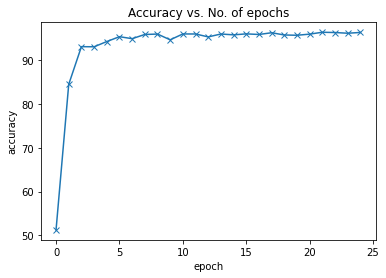

In [141]:
plot_accuracies(history)

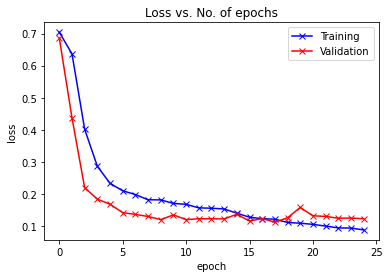

In [142]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

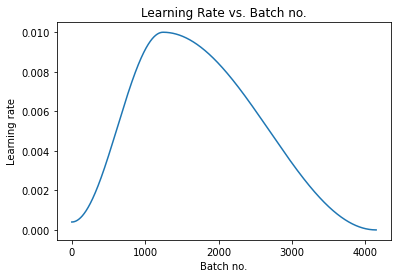

In [143]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

In [182]:
final_test_details = [evaluate(model, test_dl1)];final_test_details

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 92.75752258300781, 'val_loss': 0.1825598180294037}]

<b> Our models final acccuracy on testing set is almost 93 %. This is very good model as it has almost 97 % accuracy on the validation set. </b>

In [183]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)

    # Get predictions from model
    yb = model(xb)

    # Applying Softmax Function 
    yb  = F.softmax(yb, dim=1)

    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)

    # Retrieve the class label
    print(preds)
    print("Probability: ",prob.item(),", Prediction: ",classes[preds.item()])
    plt.imshow(denormalize_the_images(img, *imagenet_stats)[0].permute(1,2,0))

tensor([1], device='cuda:0')
Probability:  0.999861478805542 , Prediction:  Male


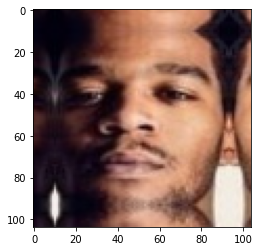

In [185]:
predict_image(train_ds[4005][0], model)

tensor([0], device='cuda:0')
Probability:  0.999272882938385 , Prediction:  Female


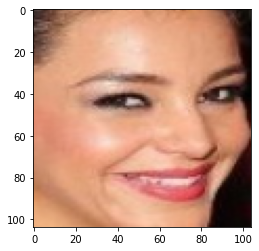

In [186]:
predict_image(test_ds[4005][0], model)

In [ ]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [201]:
test_transformer = T.Compose([T.Resize((104,104)),  # resizing all images into 250*250 pixels 
                        T.ToTensor(),
                         T.Normalize(*imagenet_stats)])

In [202]:
pranil = open_image('pranil.png')

tensor([1], device='cuda:0')
Probability:  0.7637120485305786 , Prediction:  Male


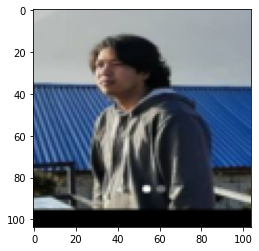

In [203]:
predict_image(test_transformer(pranil), model)

tensor([1], device='cuda:0')
Probability:  0.9999630451202393 , Prediction:  Male


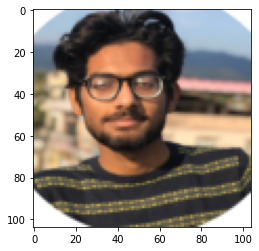

In [204]:
navaraj = open_image('navaraj.png')
predict_image(test_transformer(navaraj), model)

tensor([1], device='cuda:0')
Probability:  0.9957834482192993 , Prediction:  Male


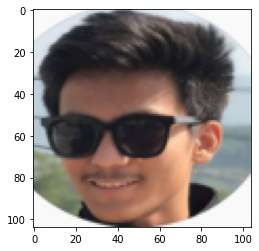

In [205]:
bishal = open_image('bishal.png')
predict_image(test_transformer(bishal), model)

tensor([1], device='cuda:0')
Probability:  0.8464627861976624 , Prediction:  Male


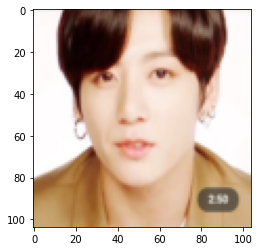

In [206]:
bts = open_image('bts.png')
predict_image(test_transformer(bts), model)

tensor([0], device='cuda:0')
Probability:  0.9884642958641052 , Prediction:  Female


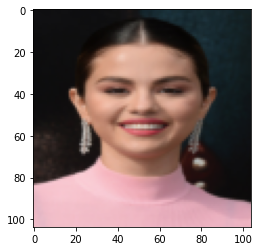

In [207]:
salena = open_image('salena.jpg')
predict_image(test_transformer(salena), model)

Thank you. Please Check My Other Projects as well